# Outcome Prediction (Node Classification) with TransE Model + MLP

In [1]:
import os
import joblib

import numpy as np
import pandas as pd

from pykeen.triples import TriplesFactory
from pykeen.predict import predict_target
from pykeen.pipeline import pipeline

## 1. Load KG and remove outcomes

In [2]:
dataset = '../Data Generation/sphn_transductive_1000_0.nt'
num_patients = 1000

def preprocess(data_name):
    s_list, r_list, d_list = [], [], []
    
    with open(data_name) as f:
        s = next(f)
        print(s)
        for idx, line in enumerate(f):
            e = line.strip().split(' ')
            s = e[0]
            r = e[1]
            d = e[2]            
            
            s_list.append(s)
            r_list.append(r)
            d_list.append(d)            
            
    return pd.DataFrame({
        's':s_list, 
        'r':r_list, 
        'd':d_list,                          
        })

df = preprocess(dataset)
print(df.head())

<http://nvasc.org/f0ebdaad-cbff-4146-9f6c-cd36ca2fa6a9> <http://sphn.org/hasSubjectPseudoIdentifier> <http://nvasc.org/synth_patient_655> .

                                                   s  \
0  <http://nvasc.org/5520b794-ce4d-429b-989b-f50a...   
1  <http://nvasc.org/e7e35917-43e4-43b0-ae9b-03ef...   
2  <http://nvasc.org/e4ee5cff-28ac-4166-8061-e702...   
3  <http://nvasc.org/ff28cf13-ce6f-4ee1-9bb7-1e27...   
4              _:n666407211fed47599e420f9104257e72b1   

                                                   r  \
0  <http://www.w3.org/1999/02/22-rdf-syntax-ns#type>   
1                      <http://sphn.org/hasQuantity>   
2                          <http://sphn.org/hasCode>   
3                      <http://sphn.org/hasQuantity>   
4                         <http://sphn.org/hasValue>   

                                       d  
0            <http://sphn.org/Diagnosis>  
1  _:n05ec718cd7f94fe28f83910c54f4011bb1  
2        <http://nvasc.org/code_hct_0.0>  
3  _:na54f2ce

### Remove outcomes from KG

In [3]:
outcome = df['d'].str.contains('outcome_0.0|outcome_1.0|outcome_2.0')
node_df = df[~outcome]
node_df = node_df.reset_index(drop=True)
outcome = node_df['s'].str.contains('outcome_0.0|outcome_1.0|outcome_2.0')
node_df = node_df[~outcome]
node_df = node_df.reset_index(drop=True)

In [4]:
ent_to_id = {k: v for v, k in enumerate(set(node_df['s']).union(set(node_df['d'])), start=0)}
rel_to_id = {k: v for v, k in enumerate(set(node_df['r']), start=0)}

patients = [f"<http://nvasc.org/synth_patient_{i}>" for i in range(num_patients)]
patient_id = []
for patient in patients:
    patient_id.append(ent_to_id[patient])

num_nodes = max(ent_to_id.values()) + 1
num_rels = max(rel_to_id.values()) + 1

events = node_df.copy()
events["s"] = node_df.s.map(ent_to_id)
events["d"] = node_df.d.map(ent_to_id)
events["r"] = node_df.r.map(rel_to_id)

ent_to_id = pd.DataFrame.from_dict(ent_to_id, orient='index')
rel_to_id = pd.DataFrame.from_dict(rel_to_id, orient='index')

### Save events, entities and relations to 'processed_data' folder

In [5]:
path = 'processed_data'
if not os.path.exists(path):
    os.makedirs(path)

events.to_csv(f'{path}/sphn_events_noOutcome.tsv', sep='\t', index=False, header=None)
ent_to_id.to_csv(f'{path}/sphn_entities_noOutcome.tsv', sep='\t', header=None)
rel_to_id.to_csv(f'{path}/sphn_relations_noOutcome.tsv', sep='\t', header=None)

## 2. Training the model

In [3]:
path = 'processed_data'
tf = TriplesFactory.from_path(f'{path}/sphn_events_noOutcome.tsv', create_inverse_triples=True)
print(tf)

TriplesFactory(num_entities=32564, num_relations=16, create_inverse_triples=True, num_triples=111934, path="/home/baical77/projects/neurovasc/notebooks/Graphs/processed_data/sphn_events_noOutcome.tsv")


No random seed is specified. Setting to 898004030.
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/50 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cuda:0:   0%|          | 0.00/112k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 192.25s seconds


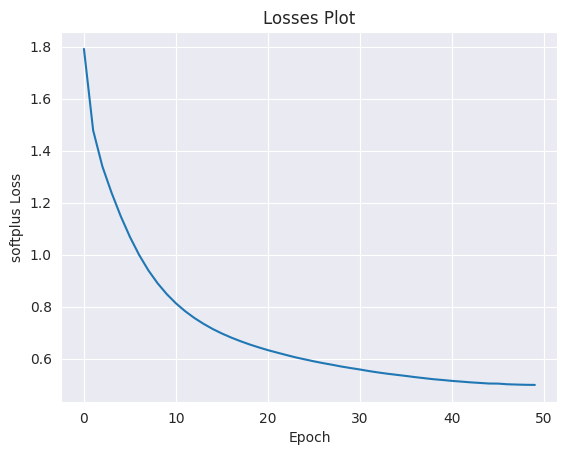

In [4]:
model_name = 'TransE'
embedding_dim = 32
epochs = 50

result = pipeline(
    training=tf,
    testing=tf,
    model=model_name,
    model_kwargs=dict(
        embedding_dim=embedding_dim,
        loss="softplus",
    ),
    training_kwargs=dict(
        num_epochs=epochs,
        label_smoothing=0.2,
        use_tqdm_batch=False,
    ),
    optimizer_kwargs=dict(
        lr=0.001,
        weight_decay=1e-5,
    ),
    training_loop='sLCWA',
    negative_sampler='basic',
    device='gpu',
    use_tqdm=True,
)

#plot loss
loss_plot = result.plot_losses()

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


num_patients = 1000
entity = pd.read_csv('processed_data/sphn_entities_noOutcome.tsv', sep='\t', index_col=0, header=None)
entity = entity.to_dict()[1]
patient_id = []
for i in range(num_patients):
    idx = f'<http://nvasc.org/synth_patient_{i}>'
    patient_id.append(entity[idx])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = result.model
entity_embedding = model.entity_representations[0](indices=None).detach().cpu()
patient_embedding = entity_embedding[patient_id]
print(f'Patient embedding size: {patient_embedding.shape}')

patient_embedding = patient_embedding.to(device)
y = joblib.load('../Data Generation/outcomes_1000_0.joblib')
y = torch.Tensor(y).long().to(device)

train_x, train_y = patient_embedding[:int(num_patients*0.8)], y[:int(num_patients*0.8)]
val_x, val_y = patient_embedding[int(num_patients*0.8):int(num_patients*0.9)], y[int(num_patients*0.8):int(num_patients*0.9)]
test_x, test_y = patient_embedding[int(num_patients*0.9):], y[int(num_patients*0.9):]

Patient embedding size: torch.Size([1000, 32])


In [18]:
# MLP classifier
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(32, 3),
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return F.log_softmax(x, dim=1)
    
model = NeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0005)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_x)
    loss = F.nll_loss(out, train_y)
    loss.backward()
    optimizer.step()
    # Validation
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        val_output = model(val_x)
        val_loss = F.nll_loss(val_output, val_y)
    return float(loss), float(val_loss)

@torch.no_grad()
def test():
    model.eval()
    pred = model(patient_embedding).argmax(dim=-1)
    train_acc = float((pred[:int(num_patients*0.8)] == train_y).float().mean())
    val_acc = float((pred[int(num_patients*0.8):int(num_patients*0.9)] == val_y).float().mean())
    test_acc = float((pred[int(num_patients*0.9):] == test_y).float().mean())
    return train_acc, val_acc, test_acc

import time

times = []
best_loss = float('inf')

for epoch in range(1, 1001):
    start = time.time()
    loss, val_loss = train()
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 50  # Reset patience counter
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping...")
            break
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val_Loss: {val_loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f} '
        f'Test: {test_acc:.4f}')
        
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 01, Loss: 1.1102, Val_Loss: 1.1125, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 02, Loss: 1.1128, Val_Loss: 1.1122, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 03, Loss: 1.1105, Val_Loss: 1.1120, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 04, Loss: 1.1095, Val_Loss: 1.1117, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 05, Loss: 1.1105, Val_Loss: 1.1114, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 06, Loss: 1.1104, Val_Loss: 1.1112, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 07, Loss: 1.1110, Val_Loss: 1.1109, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 08, Loss: 1.1082, Val_Loss: 1.1107, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 09, Loss: 1.1120, Val_Loss: 1.1104, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 10, Loss: 1.1114, Val_Loss: 1.1102, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 11, Loss: 1.1076, Val_Loss: 1.1099, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 12, Loss: 1.1111, Val_Loss: 1.1097, Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoc

In [19]:
from sklearn.metrics import roc_auc_score

model.eval()
with torch.no_grad():
    out = model(patient_embedding).cpu()
    prob = F.softmax(out, dim=1)
auc = roc_auc_score(test_y.cpu(), prob[int(num_patients*0.9):], multi_class='ovr')
print(f'ROC AUC score: {auc:.4f}')

ROC AUC score: 0.5183
